In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest

class CreditAnalyzer:
    def __init__(self):
        self.scaler = RobustScaler()
        self.isolation_forest = IsolationForest(
            random_state=42,
            n_estimators=200
        )

    def get_numeric_features(self, df):
        """수치형 특성 추출"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        features = [col for col in numeric_cols if not col.startswith('Unnamed')]
        exclude_cols = ['is_anomaly']
        features = [col for col in features if col not in exclude_cols]
        return features

    def add_risk_score(self, df):
        """이상치 탐지 결과를 바탕으로 risk_score 추가"""
        df['risk_score'] = np.where(df['is_anomaly'], '불량', '우량')

        # 기본 통계 출력
        risk_counts = df['risk_score'].value_counts()
        print("\n=== Risk Score 분포 ===")
        print("\n레이블별 건수:")
        print(f"우량: {risk_counts['우량']:,}건 ({risk_counts['우량']/len(df)*100:.2f}%)")
        print(f"불량: {risk_counts['불량']:,}건 ({risk_counts['불량']/len(df)*100:.2f}%)")

        # 생애주기별 risk_score 분포
        if 'LIFE_STAGE' in df.columns:
            print("\n생애주기별 Risk Score 분포:")
            life_stage_risk = pd.crosstab(df['LIFE_STAGE'], df['risk_score'], normalize='index') * 100
            print(life_stage_risk.round(2))

        return df

def main():
    # 분석기 초기화
    analyzer = CreditAnalyzer()

    # 데이터 로드
    df = pd.read_csv('sampling_8Q.csv')

    # 전처리: 무한값을 NaN으로 변경 후 중앙값으로 대체
    for col in df.select_dtypes(include=[np.number]).columns:
        inf_count = df[col].isin([float('inf'), float('-inf')]).sum()
        if inf_count > 0:
            print(f"{col}: {inf_count}개의 무한값 발견")
        df[col] = df[col].replace([float('inf'), float('-inf')], np.nan)
        df[col] = df[col].fillna(df[col].median())

    # 분석할 특성 자동 선택
    features = analyzer.get_numeric_features(df)

    # 이상치 탐지
    scaled_data = analyzer.scaler.fit_transform(df[features])
    df['is_anomaly'] = analyzer.isolation_forest.fit_predict(scaled_data) == -1

    # risk_score 추가
    df = analyzer.add_risk_score(df)

    # 결과 저장 (선택사항)
    df.to_csv('sampling_8Q_with_risk.csv', index=False)

    return df

if __name__ == "__main__":
    df_result = main()

# 결과 데이터프레임의 처음 몇 행 확인
print("\n처음 5개 행의 risk_score:")
print(df_result[['LIFE_STAGE', 'is_anomaly', 'risk_score']].head())

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

class CreditAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.rf = RandomForestClassifier(n_estimators=100, random_state=42)

    def save_models(self, regression_results, df_prepared, importance_df, file_prefix='credit_model'):
        """모델과 관련 객체들을 피클로 저장"""
        top_features = importance_df.head(15)['feature'].tolist()
        if 'quarter_seq' not in top_features:
            top_features.append('quarter_seq')

        final_scaler = StandardScaler()
        final_scaler.fit(df_prepared[top_features])

        model_info = {
            'coefficients': regression_results.params,
            'feature_names': regression_results.params.index,
            'scaler': final_scaler,
            'rf_model': self.rf,
            'importance_df': importance_df,
            'required_features': top_features
        }

        with open(f'{file_prefix}.pkl', 'wb') as f:
            pickle.dump(model_info, f)

        print("\n=== 모델 저장 완료 ===")
        print(f"파일명: {file_prefix}.pkl")
        print("- 필요 변수 목록:", top_features)

    def prepare_data(self, df):
        """시계열 데이터 전처리"""
        quarter_map = {
            '2022q1': 1, '2022q2': 2, '2022q3': 3, '2022q4': 4,
            '2023q1': 5, '2023q2': 6, '2023q3': 7, '2023q4': 8
        }
        df['quarter_seq'] = df['BAS_YH'].map(quarter_map)

        columns_to_drop = ['Unnamed: 0', 'SEQ', 'is_anomaly',
                          'BAS_YH_year', 'BAS_YH_numeric', 'BAS_YH']
        df = df.drop(columns_to_drop, axis=1, errors='ignore')

        categorical_cols = ['HOUS_SIDO_NM', 'DIGT_CHNL_REG_YN',
                          'DIGT_CHNL_USE_YN', 'LIFE_STAGE']
        le = LabelEncoder()
        for col in categorical_cols:
            if col in df.columns:
                df[col] = le.fit_transform(df[col])

        df['risk_score'] = (df['risk_score'] == '불량').astype(int)

        return df

    def analyze_importance(self, df):
        """Random Forest 변수 중요도 분석"""
        X = df.drop('risk_score', axis=1)
        y = df['risk_score']
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        self.rf.fit(X_scaled, y)
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': self.rf.feature_importances_
        }).sort_values('importance', ascending=False)
        print("=== Random Forest 변수 중요도 (상위 15개) ===")
        print(importance_df.head(15).round(4))
        return importance_df, X_scaled

    def perform_logistic_regression(self, df, importance_df):
        """로지스틱 회귀 분석 수행"""
        top_features = importance_df.head(15)['feature'].tolist()
        if 'quarter_seq' not in top_features:
            top_features.append('quarter_seq')

        X = df[top_features]
        y = df['risk_score']
        X = sm.add_constant(X)
        logit_model = sm.Logit(y, X)
        results = logit_model.fit()
        print("\n=== 로지스틱 회귀 분석 결과 ===")
        print(results.summary())
        return results

    def calculate_credit_score_with_refined_distribution(self, df, coef):
        """더 세분화된 신용 점수 계산 (600~1000점 범위)"""
        weight_adjustments = {
            'UES_INCOME': 0.5,
            'DAN_RT': 0.7,
            'CRDSL_USE_AM': 2.0,
            'DIST_AM': 2.0
        }

        adjusted_coef = coef.copy()
        for var, weight in weight_adjustments.items():
            if var in adjusted_coef.index:
                adjusted_coef[var] *= weight

        X = sm.add_constant(df)
        X = X[adjusted_coef.index]
        logit_score = np.dot(X, adjusted_coef)

        percentile_rank = pd.Series(logit_score).rank(pct=True)

        def transform_to_credit_score(rank):
            if rank >= 0.5506:  # 상위 44.94% (900점 이상)
                base_score = 900
                additional = (rank - 0.5506) / (1 - 0.5506) * 100
                return base_score + additional
            elif rank >= 0.3134:  # 상위 68.66% (800-900점)
                base_score = 800
                additional = (rank - 0.3134) / (0.5506 - 0.3134) * 100
                return base_score + additional
            elif rank >= 0.0592:  # 상위 94.08% (700-800점)
                base_score = 700
                additional = (rank - 0.0592) / (0.3134 - 0.0592) * 100
                return base_score + additional
            elif rank >= 0.0438:  # 상위 95.62% (600-700점)
                base_score = 600
                additional = (rank - 0.0438) / (0.0592 - 0.0438) * 100
                return base_score + additional
            else:  # 하위 4.38% (300-600점)
                return 300 + (rank / 0.0438) * 300  # 300-600점 사이에 분포

        credit_scores = percentile_rank.apply(transform_to_credit_score)
        return credit_scores.round(0)

    def get_credit_grade(self, score):
        """신용 점수를 등급으로 변환"""
        if score >= 900:
            return '1등급'
        elif score >= 800:
            return '2등급'
        elif score >= 700:
            return '3등급'
        elif score >= 600:
            return '4등급'
        else:
            return '5등급'

    def analyze_score_distribution(self, scores):
        """점수 분포 분석"""
        print("\n=== 신용 점수 분포 분석 ===")

        bins = [0, 599.5, 699.5, 799.5, 899.5, 1000]
        labels = ['600미만', '600~699', '700~799', '800~899', '900이상']
        grade_counts = pd.cut(scores,
                            bins=bins,
                            labels=labels,
                            right=True).value_counts().sort_index()

        total = len(scores)
        print("\n목표 분포:")
        print("900점 이상: 44.94%")
        print("800-899점: 23.72%")
        print("700-799점: 25.42%")
        print("600-699점: 1.54%")
        print("600점 미만: 4.38%")

        print("\n실제 점수 구간별 분포:")
        for grade, count in grade_counts.items():
            percentage = (count/total) * 100
            print(f"{grade}: {count:,}명 ({percentage:.2f}%)")

        print("\n기술 통계량:")
        print(scores.describe().round(2))

        percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
        print("\n주요 백분위수:")
        for p in percentiles:
            score = np.percentile(scores, p)
            print(f"{p}번째 백분위: {score:.1f}점")

    def visualize_results(self, df):
        """결과 시각화"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x='credit_score', bins=50)
        plt.title('신용 점수 분포')
        plt.xlabel('신용 점수')
        plt.ylabel('빈도')

        plt.subplot(1, 2, 2)
        sns.countplot(data=df, x='credit_grade',
                     order=['1등급', '2등급', '3등급', '4등급', '5등급'])
        plt.title('신용 등급 분포')
        plt.xlabel('신용 등급')
        plt.ylabel('빈도')

        plt.tight_layout()
        plt.show()

def main():
    analyzer = CreditAnalyzer()
    df = pd.read_csv('sampling_8Q_with_risk.csv')
    df_prepared = analyzer.prepare_data(df)
    importance_df, X_scaled = analyzer.analyze_importance(df_prepared)
    regression_results = analyzer.perform_logistic_regression(df_prepared, importance_df)

    df_prepared['credit_score'] = analyzer.calculate_credit_score_with_refined_distribution(
        df_prepared[regression_results.params.index[1:]],
        regression_results.params
    )

    df_prepared['credit_grade'] = df_prepared['credit_score'].apply(analyzer.get_credit_grade)

    analyzer.analyze_score_distribution(df_prepared['credit_score'])
    analyzer.visualize_results(df_prepared)
    analyzer.save_models(regression_results, df_prepared, importance_df)

    return df_prepared

if __name__ == "__main__":
    df_result = main()

=== Random Forest 변수 중요도 (상위 15개) ===
           feature  importance
8       TOT_USE_AM      0.1991
24      UES_INCOME      0.1807
9     CRDSL_USE_AM      0.0934
10      CNF_USE_AM      0.0590
18      PLSANIT_AM      0.0398
15         FSBZ_AM      0.0350
14       TRVLEC_AM      0.0335
26          DAN_RT      0.0327
17         DIST_AM      0.0324
29  LIFE_STAGE_DAN      0.0220
19     CLOTHGDS_AM      0.0217
3           ATT_YM      0.0215
22            DEBT      0.0197
28      DEBT_RATIO      0.0183
23          INCOME      0.0181
Optimization terminated successfully.
         Current function value: 0.112792
         Iterations 10

=== 로지스틱 회귀 분석 결과 ===
                           Logit Regression Results                           
Dep. Variable:             risk_score   No. Observations:               720008
Model:                          Logit   Df Residuals:                   719991
Method:                           MLE   Df Model:                           16
Date:                Tue

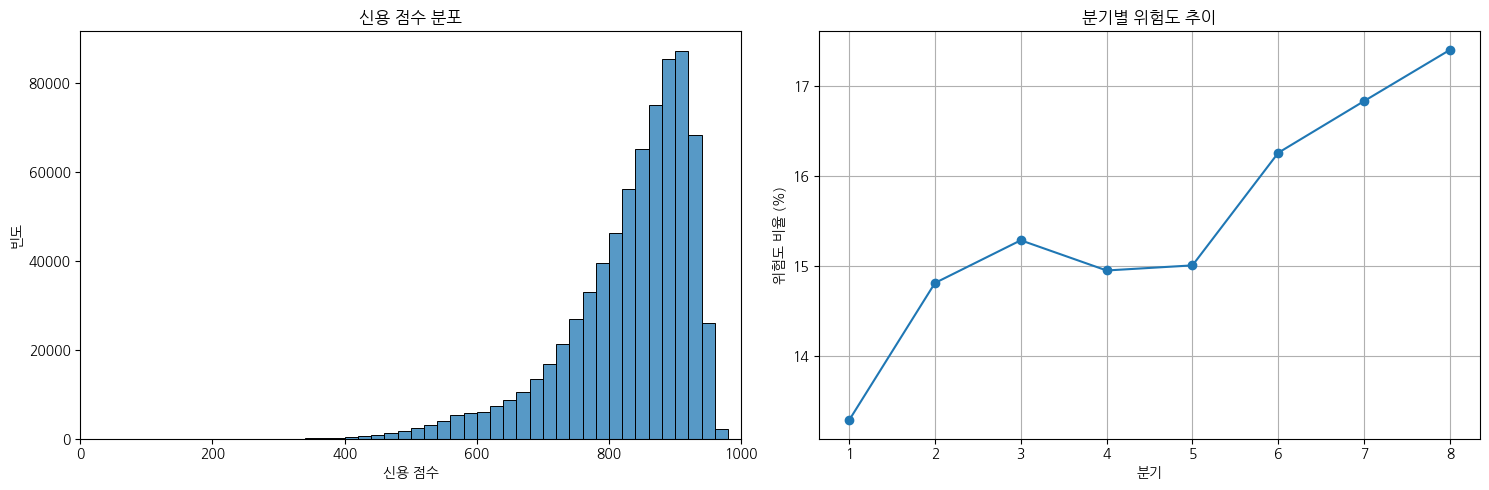


=== 모델 저장 완료 ===
파일명: credit_model.pkl

포함된 정보:
- 로지스틱 회귀 계수
- 필요 변수 목록: ['TOT_USE_AM', 'UES_INCOME', 'CRDSL_USE_AM', 'CNF_USE_AM', 'PLSANIT_AM', 'FSBZ_AM', 'TRVLEC_AM', 'DAN_RT', 'DIST_AM', 'LIFE_STAGE_DAN', 'CLOTHGDS_AM', 'ATT_YM', 'DEBT', 'DEBT_RATIO', 'INCOME', 'quarter_seq']
- StandardScaler
- Random Forest 모델
- 변수 중요도 정보


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

class CreditAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.rf = RandomForestClassifier(n_estimators=100, random_state=42)

    def save_models(self, regression_results, df_prepared, importance_df, file_prefix='credit_model'):
        """모델과 관련 객체들을 피클로 저장"""
        import pickle

        # 상위 15개 중요 변수 선택 (quarter_seq 포함)
        top_features = importance_df.head(15)['feature'].tolist()
        if 'quarter_seq' not in top_features:
            top_features.append('quarter_seq')

        # 최종 사용된 피처들에 대해 스케일러 재학습
        final_scaler = StandardScaler()
        final_scaler.fit(df_prepared[top_features])

        # 1. 모델 정보를 딕셔너리로 구성
        model_info = {
            'coefficients': regression_results.params,
            'feature_names': regression_results.params.index,
            'scaler': final_scaler,
            'rf_model': self.rf,
            'importance_df': importance_df,
            'required_features': top_features
        }

        # 2. 피클 파일로 저장
        with open(f'{file_prefix}.pkl', 'wb') as f:
            pickle.dump(model_info, f)

        print("\n=== 모델 저장 완료 ===")
        print(f"파일명: {file_prefix}.pkl")
        print("\n포함된 정보:")
        print("- 로지스틱 회귀 계수")
        print("- 필요 변수 목록:", top_features)
        print("- StandardScaler")
        print("- Random Forest 모델")
        print("- 변수 중요도 정보")

    def prepare_data(self, df):
        """시계열 데이터 전처리"""
        # 분기 매핑
        quarter_map = {
            '2022q1': 1, '2022q2': 2, '2022q3': 3, '2022q4': 4,
            '2023q1': 5, '2023q2': 6, '2023q3': 7, '2023q4': 8
        }

        # 분기 정보 변환
        df['quarter_seq'] = df['BAS_YH'].map(quarter_map)

        # 불필요한 컬럼 제거
        columns_to_drop = ['Unnamed: 0', 'SEQ', 'is_anomaly',
                          'BAS_YH_year', 'BAS_YH_numeric', 'BAS_YH']
        df = df.drop(columns_to_drop, axis=1, errors='ignore')

        # 범주형 변수 처리
        categorical_cols = ['HOUS_SIDO_NM', 'DIGT_CHNL_REG_YN',
                          'DIGT_CHNL_USE_YN', 'LIFE_STAGE']

        le = LabelEncoder()
        for col in categorical_cols:
            if col in df.columns:
                df[col] = le.fit_transform(df[col])

        # 종속변수 변환
        df['risk_score'] = (df['risk_score'] == '불량').astype(int)

        return df

    def analyze_importance(self, df):
        """Random Forest 변수 중요도 분석"""
        X = df.drop('risk_score', axis=1)
        y = df['risk_score']

        # 변수 스케일링
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

        # Random Forest 학습
        self.rf.fit(X_scaled, y)

        # 변수 중요도 계산
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': self.rf.feature_importances_
        }).sort_values('importance', ascending=False)

        print("=== Random Forest 변수 중요도 (상위 15개) ===")
        print(importance_df.head(15).round(4))

        return importance_df, X_scaled

    def perform_logistic_regression(self, df, importance_df):
        """로지스틱 회귀 분석 수행 및 성능 평가"""
        # 상위 15개 변수 선택 (quarter_seq 포함)
        top_features = importance_df.head(15)['feature'].tolist()
        if 'quarter_seq' not in top_features:
            top_features.append('quarter_seq')

        X = df[top_features]
        y = df['risk_score']

        # 로지스틱 회귀 분석
        X = sm.add_constant(X)
        logit_model = sm.Logit(y, X)
        results = logit_model.fit()

        # 예측 확률 계산
        y_pred_proba = results.predict(X)
        # 확률을 0, 1로 변환 (임계값 0.5)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # 성능 지표 계산
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        conf_matrix = confusion_matrix(y, y_pred)

        print("\n=== 로지스틱 회귀 분석 결과 ===")
        print(results.summary())

        print("\n=== 모델 성능 지표 ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        print("\n=== 혼동 행렬 ===")
        print("예측\t불량\t정상")
        print(f"실제 불량\t{conf_matrix[1][1]}\t{conf_matrix[1][0]}")
        print(f"실제 정상\t{conf_matrix[0][1]}\t{conf_matrix[0][0]}")

        # Odds Ratio 계산
        print("\n=== Odds Ratio ===")
        odds_ratios = pd.DataFrame({
            'Variable': results.params.index,
            'Odds_Ratio': np.exp(results.params),
            'CI_Lower': np.exp(results.conf_int()[0]),
            'CI_Upper': np.exp(results.conf_int()[1])
        })
        print(odds_ratios.round(4))

        return results, odds_ratios

    def calculate_credit_score(self, df, coef):
        """신용 점수 계산 - 수정된 계산 방식"""
        # 변수별 조정된 가중치 설정
        weight_adjustments = {
            'UES_INCOME': 0.5,  # 가중치 감소
            'DAN_RT': 0.7,      # 가중치 감소
            'CRDSL_USE_AM': 2.0, # 가중치 증가
            'DIST_AM': 2.0       # 가중치 증가
        }

        # 계수 수정: 조정된 가중치를 곱함
        adjusted_coef = coef.copy()
        for var, weight in weight_adjustments.items():
            if var in adjusted_coef.index:
                adjusted_coef[var] *= weight

        # 상수항을 위한 1 추가
        X = sm.add_constant(df)

        # 계수에 있는 변수들만 선택
        X = X[adjusted_coef.index]

        # 스케일링된 점수 계산
        scaled_score = np.dot(X, adjusted_coef)

        # Min-Max 스케일링 적용
        scaled_score = (scaled_score - scaled_score.min()) / (scaled_score.max() - scaled_score.min())

        # 기본 점수 (양호한 신용 = 높은 점수)
        base_score = 1000

        # 최종 신용점수 계산 (역변환: 위험도가 높을수록 신용점수는 낮아짐)
        credit_score = base_score * (1 - scaled_score)

        return credit_score

    def label_credit_score(self, score):
        """신용 점수를 등급으로 변환 - 백분위 기반"""
        def get_percentile(x):
            return pd.qcut(x, q=6, labels=['6등급', '5등급', '4등급', '3등급', '2등급', '1등급'])

        if isinstance(score, pd.Series):
            return get_percentile(score)
        else:
            temp_series = pd.Series([score])
            return get_percentile(temp_series)[0]

    def analyze_trends(self, df):
        """시계열 트렜드 분석"""
        print("\n=== 분기별 위험도 분포 ===")
        quarter_risk = df.groupby('quarter_seq')['risk_score'].agg(['mean', 'count'])
        quarter_risk['risk_ratio'] = quarter_risk['mean'] * 100
        print(quarter_risk.round(4))

        # 주요 변수의 분기별 평균
        important_vars = df.columns[:5]
        print("\n=== 분기별 주요 변수 평균 추이 ===")
        quarterly_means = df.groupby('quarter_seq')[important_vars].mean()
        print(quarterly_means.round(4))

        return quarter_risk, quarterly_means

    def visualize_results(self, df, quarter_risk):
        """결과 시각화"""
        plt.figure(figsize=(15, 5))

        # 신용점수 분포
        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x='credit_score', bins=50)
        plt.title('신용 점수 분포')
        plt.xlabel('신용 점수')
        plt.ylabel('빈도')

        # x축 범위 설정
        plt.xlim(0, 1000)

        # 분기별 위험도 추이
        plt.subplot(1, 2, 2)
        plt.plot(quarter_risk.index, quarter_risk['risk_ratio'], marker='o')
        plt.title('분기별 위험도 추이')
        plt.xlabel('분기')
        plt.ylabel('위험도 비율 (%)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def main():
    # 분석기 초기화
    analyzer = CreditAnalyzer()

    # 데이터 로드
    df = pd.read_csv('sampling_8Q_with_risk.csv')

    # 데이터 전처리
    df_prepared = analyzer.prepare_data(df)

    # Random Forest 중요도 분석
    importance_df, X_scaled = analyzer.analyze_importance(df_prepared)

    # 로지스틱 회귀 분석
    regression_results, odds_ratios = analyzer.perform_logistic_regression(
        df_prepared, importance_df)

    # 신용 점수 계산
    df_prepared['credit_score'] = analyzer.calculate_credit_score(
        df_prepared[regression_results.params.index[1:]],
        regression_results.params)

    # 신용 등급 라벨링
    df_prepared['credit_grade'] = analyzer.label_credit_score(df_prepared['credit_score'])

    # 트렜드 분석
    quarter_risk, quarterly_means = analyzer.analyze_trends(df_prepared)

    # 결과 시각화
    analyzer.visualize_results(df_prepared, quarter_risk)

    # 결과 저장
    df_prepared.to_csv('credit_analysis_results.csv', index=False)

    # 모델 저장
    analyzer.save_models(regression_results, df_prepared, importance_df)

    return df_prepared, regression_results, importance_df

if __name__ == "__main__":
    df_result, regression_results, importance_df = main()

In [3]:
!pip install koreanize-matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 14.1 MB/s eta 0:00:00


=== Random Forest 변수 중요도 (상위 15개) ===
           feature  importance
8       TOT_USE_AM      0.1991
24      UES_INCOME      0.1807
9     CRDSL_USE_AM      0.0934
10      CNF_USE_AM      0.0590
18      PLSANIT_AM      0.0398
15         FSBZ_AM      0.0350
14       TRVLEC_AM      0.0335
26          DAN_RT      0.0327
17         DIST_AM      0.0324
29  LIFE_STAGE_DAN      0.0220
19     CLOTHGDS_AM      0.0217
3           ATT_YM      0.0215
22            DEBT      0.0197
28      DEBT_RATIO      0.0183
23          INCOME      0.0181
Optimization terminated successfully.
         Current function value: 0.112792
         Iterations 10

=== 로지스틱 회귀 분석 결과 ===
                           Logit Regression Results                           
Dep. Variable:             risk_score   No. Observations:               720008
Model:                          Logit   Df Residuals:                   719991
Method:                           MLE   Df Model:                           16
Date:                Tue

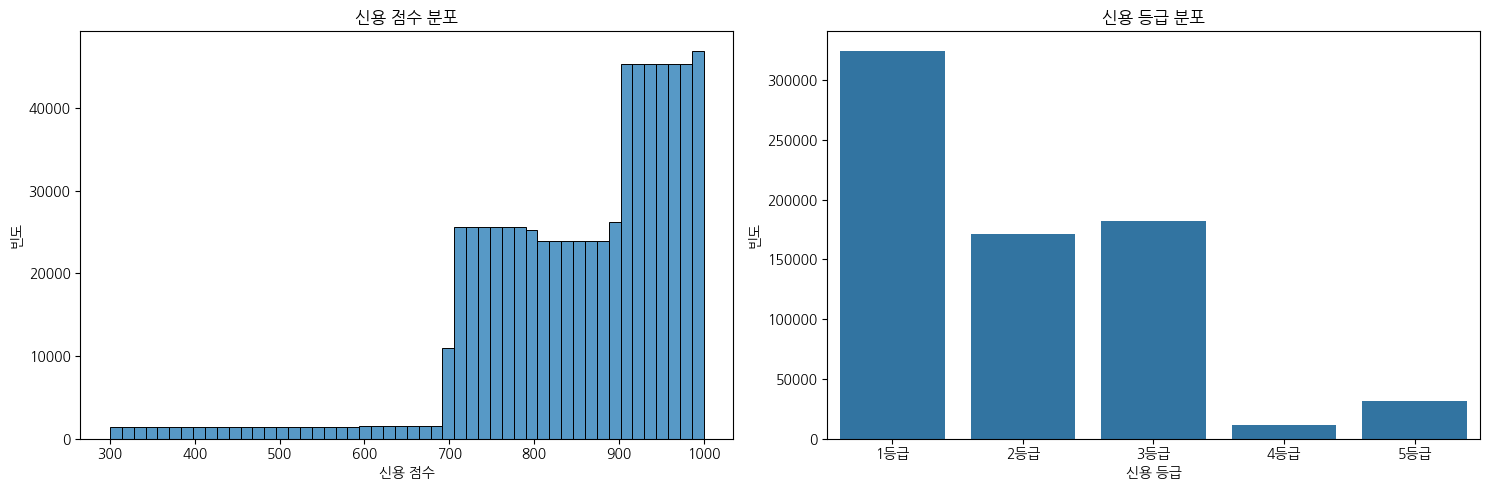


=== 모델 저장 완료 ===
파일명: credit_model.pkl
- 필요 변수 목록: ['TOT_USE_AM', 'UES_INCOME', 'CRDSL_USE_AM', 'CNF_USE_AM', 'PLSANIT_AM', 'FSBZ_AM', 'TRVLEC_AM', 'DAN_RT', 'DIST_AM', 'LIFE_STAGE_DAN', 'CLOTHGDS_AM', 'ATT_YM', 'DEBT', 'DEBT_RATIO', 'INCOME', 'quarter_seq']


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

class CreditAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.rf = RandomForestClassifier(n_estimators=100, random_state=42)

    def save_models(self, regression_results, df_prepared, importance_df, file_prefix='credit_model'):
        """모델과 관련 객체들을 피클로 저장"""
        top_features = importance_df.head(15)['feature'].tolist()
        if 'quarter_seq' not in top_features:
            top_features.append('quarter_seq')

        final_scaler = StandardScaler()
        final_scaler.fit(df_prepared[top_features])

        model_info = {
            'coefficients': regression_results.params,
            'feature_names': regression_results.params.index,
            'scaler': final_scaler,
            'rf_model': self.rf,
            'importance_df': importance_df,
            'required_features': top_features
        }

        with open(f'{file_prefix}.pkl', 'wb') as f:
            pickle.dump(model_info, f)

        print("\n=== 모델 저장 완료 ===")
        print(f"파일명: {file_prefix}.pkl")
        print("- 필요 변수 목록:", top_features)

    def prepare_data(self, df):
        """시계열 데이터 전처리"""
        quarter_map = {
            '2022q1': 1, '2022q2': 2, '2022q3': 3, '2022q4': 4,
            '2023q1': 5, '2023q2': 6, '2023q3': 7, '2023q4': 8
        }
        df['quarter_seq'] = df['BAS_YH'].map(quarter_map)

        columns_to_drop = ['Unnamed: 0', 'SEQ', 'is_anomaly',
                          'BAS_YH_year', 'BAS_YH_numeric', 'BAS_YH']
        df = df.drop(columns_to_drop, axis=1, errors='ignore')

        categorical_cols = ['HOUS_SIDO_NM', 'DIGT_CHNL_REG_YN',
                          'DIGT_CHNL_USE_YN', 'LIFE_STAGE']
        le = LabelEncoder()
        for col in categorical_cols:
            if col in df.columns:
                df[col] = le.fit_transform(df[col])

        df['risk_score'] = (df['risk_score'] == '불량').astype(int)

        return df

    def analyze_importance(self, df):
        """Random Forest 변수 중요도 분석"""
        X = df.drop('risk_score', axis=1)
        y = df['risk_score']
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        self.rf.fit(X_scaled, y)
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': self.rf.feature_importances_
        }).sort_values('importance', ascending=False)
        print("=== Random Forest 변수 중요도 (상위 15개) ===")
        print(importance_df.head(15).round(4))
        return importance_df, X_scaled

    def perform_logistic_regression(self, df, importance_df):
        """로지스틱 회귀 분석 수행"""
        top_features = importance_df.head(15)['feature'].tolist()
        if 'quarter_seq' not in top_features:
            top_features.append('quarter_seq')

        X = df[top_features]
        y = df['risk_score']
        X = sm.add_constant(X)
        logit_model = sm.Logit(y, X)
        results = logit_model.fit()

        # 예측 및 성능 지표 계산
        y_pred_proba = results.predict(X)
        y_pred = (y_pred_proba > 0.5).astype(int)

        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        conf_matrix = confusion_matrix(y, y_pred)

        print("\n=== 로지스틱 회귀 분석 결과 ===")
        print(results.summary())

        print("\n=== 모델 성능 지표 ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        print("\n=== 혼동 행렬 ===")
        print("예측\t불량\t정상")
        print(f"실제 불량\t{conf_matrix[1][1]}\t{conf_matrix[1][0]}")
        print(f"실제 정상\t{conf_matrix[0][1]}\t{conf_matrix[0][0]}")

        return results

    def calculate_credit_score_with_refined_distribution(self, df, coef):
        """더 세분화된 신용 점수 계산 (600~1000점 범위)"""
        weight_adjustments = {
            'UES_INCOME': 0.5,
            'DAN_RT': 0.7,
            'CRDSL_USE_AM': 2.0,
            'DIST_AM': 2.0
        }

        adjusted_coef = coef.copy()
        for var, weight in weight_adjustments.items():
            if var in adjusted_coef.index:
                adjusted_coef[var] *= weight

        X = sm.add_constant(df)
        X = X[adjusted_coef.index]
        logit_score = np.dot(X, adjusted_coef)

        percentile_rank = pd.Series(logit_score).rank(pct=True)

        def transform_to_credit_score(rank):
            if rank >= 0.5506:  # 상위 44.94% (900점 이상)
                base_score = 900
                additional = (rank - 0.5506) / (1 - 0.5506) * 100
                return base_score + additional
            elif rank >= 0.3134:  # 상위 68.66% (800-900점)
                base_score = 800
                additional = (rank - 0.3134) / (0.5506 - 0.3134) * 100
                return base_score + additional
            elif rank >= 0.0592:  # 상위 94.08% (700-800점)
                base_score = 700
                additional = (rank - 0.0592) / (0.3134 - 0.0592) * 100
                return base_score + additional
            elif rank >= 0.0438:  # 상위 95.62% (600-700점)
                base_score = 600
                additional = (rank - 0.0438) / (0.0592 - 0.0438) * 100
                return base_score + additional
            else:  # 하위 4.38% (300-600점)
                return 300 + (rank / 0.0438) * 300  # 300-600점 사이에 분포

        credit_scores = percentile_rank.apply(transform_to_credit_score)
        return credit_scores.round(0)

    def get_credit_grade(self, score):
        """신용 점수를 등급으로 변환"""
        if score >= 900:
            return '1등급'
        elif score >= 800:
            return '2등급'
        elif score >= 700:
            return '3등급'
        elif score >= 600:
            return '4등급'
        else:
            return '5등급'

    def analyze_score_distribution(self, scores):
        """점수 분포 분석"""
        print("\n=== 신용 점수 분포 분석 ===")

        bins = [0, 599.5, 699.5, 799.5, 899.5, 1000]
        labels = ['600미만', '600~699', '700~799', '800~899', '900이상']
        grade_counts = pd.cut(scores,
                            bins=bins,
                            labels=labels,
                            right=True).value_counts().sort_index()

        total = len(scores)
        print("\n목표 분포:")
        print("900점 이상: 44.94%")
        print("800-899점: 23.72%")
        print("700-799점: 25.42%")
        print("600-699점: 1.54%")
        print("600점 미만: 4.38%")

        print("\n실제 점수 구간별 분포:")
        for grade, count in grade_counts.items():
            percentage = (count/total) * 100
            print(f"{grade}: {count:,}명 ({percentage:.2f}%)")

        print("\n기술 통계량:")
        print(scores.describe().round(2))

        percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
        print("\n주요 백분위수:")
        for p in percentiles:
            score = np.percentile(scores, p)
            print(f"{p}번째 백분위: {score:.1f}점")

    def visualize_results(self, df):
        """결과 시각화"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x='credit_score', bins=50)
        plt.title('신용 점수 분포')
        plt.xlabel('신용 점수')
        plt.ylabel('빈도')

        plt.subplot(1, 2, 2)
        sns.countplot(data=df, x='credit_grade',
                     order=['1등급', '2등급', '3등급', '4등급', '5등급'])
        plt.title('신용 등급 분포')
        plt.xlabel('신용 등급')
        plt.ylabel('빈도')

        plt.tight_layout()
        plt.show()

def main():
    analyzer = CreditAnalyzer()
    df = pd.read_csv('sampling_8Q_with_risk.csv')
    df_prepared = analyzer.prepare_data(df)
    importance_df, X_scaled = analyzer.analyze_importance(df_prepared)
    regression_results = analyzer.perform_logistic_regression(df_prepared, importance_df)

    df_prepared['credit_score'] = analyzer.calculate_credit_score_with_refined_distribution(
        df_prepared[regression_results.params.index[1:]],
        regression_results.params
    )

    df_prepared['credit_grade'] = df_prepared['credit_score'].apply(analyzer.get_credit_grade)

    analyzer.analyze_score_distribution(df_prepared['credit_score'])
    analyzer.visualize_results(df_prepared)
    analyzer.save_models(regression_results, df_prepared, importance_df)

    return df_prepared

if __name__ == "__main__":
    df_result = main()
